# 2025.05.26

## TODO:
- [ ] Figure out coupling between conduit and atmosphere (what is conserved?)
    - [ ] Similarly, I am finding that the eruption actually behaves differently with the atmospheric coupling. Need to figure out how this works 
- [x] Simplify eruption model to have clean eruption
- [x] Inspect mesh, make sure that the number of cells is greater conduit.
- [x] For model v12 increase the fidelity (number of timesteps of the model)
- [ ] Wait; don't I need a delta t for my lighthill volume integral? 


In [532]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [533]:
import matplotlib.pyplot as plt 

plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

In [534]:
from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func
from helper_code.animate import animate_conduit_pressure

import helper_code.infrasound as infrasound
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

folder_name = "simple_conduit"

ITERS = 50
D_ITERS = 1
END_TIME = 20
C0 = 320 # m/s at 5000m

## 1.0 Back to the basics! Simple eruption model

Let's calculate $p_0$, the pressure just to the left of the plug. 

$$
\begin{align}
M \ddot{s} &= A (p_0 + \Delta p(s(t))) - p_{atm}A - Mg - 2 \pi R \tau(s(t)) \\
p_0 &= p_{atm} + \frac{2 L \tau_p}{R} + \rho L g \\
p_0 &= 1e5 + \frac{2* 50 [m] * 1e6 [Pa]}{10 [m]} + 2.6e3 [kg/m^3] * 50[m] * 9.8[m/s^2] \\
p_0 &= 11.4e6 \\
\end{align}
$$

And then $P_L$ will need to also take into account gravity:

$$
\begin{align}
p_L &= p_0 + g L \rho \\
p_L &= 11.4e6 + 950 [m] * 9.8 [m/s^2] * 2.6e3 [kg/m^3] \\
p_l &= 36.6e6
\end{align}
$$

When I run the simulation with these parameters, there is minor settling but basically the quail code agrees this is a steady state solution. 

In [535]:
file_name = "short_plug_v11"

solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(
    solver_func,
    iterations=ITERS,
    d_iterations=D_ITERS,
    viscosity_index=2,
    wall_friction_index=1,
    max_velocity=10,
    max_slip=60,
    max_tau=1.5,
    max_pressure=50,
    max_speed_of_sound=1000,
    max_water=1,
    max_density=5e3,
    max_fragmentation=5000,
    max_crystal=100,
    max_viscosity=0.1,
    show_p0_line=True,
)

ani.save(
    f"{BASE_PATH}/volcano_sims/notebooks/animations/basic_simulation_with_slip.mp4",
    writer="ffmpeg",
    fps=10,
    bitrate=1800,
)

HTML(ani.to_html5_video())

We have [previously shown](https://paxtonsc.github.io/files/geophysics/volcano_project/weekly_notes/2025.03.07.experiments.html), that the system is unstable when 

$$
D_c < \frac{L_m L_p (\tau_p - \tau_r)}{RK}
$$

In this case:

$$
\begin{align}
D_c &< \frac{950 [m] * 50 [m] * 1e6 [Pa]}{10 [m] * 1e9 [Pa]} \\
D_c &< 4.7 \\
\end{align}
$$


So lets drop the $D_c$ value down to 3. As we can see below, that (along with a slight instability in initial conditions) is sufficient to precipitate an eruption.  

Based on the numerical steady state above, we find that the **steady state conditions** are actually:

$P_L = 3.57e7$
$P_0 = 11.33e6$

When I plug those values in, no eruption! In fact, I need to increase the values marginally **to tip the eruption off**:

$P_L = 3.7e7$
$P_0 = 11.5e6$

Does the trick. 

In [536]:
file_name = "short_plug_v12"
iters = 50
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(solver_func, iterations=iters, d_iterations=D_ITERS, viscosity_index=2, wall_friction_index=1, max_velocity=5, max_slip=60, max_tau=1.5, max_pressure=50, max_speed_of_sound=1000, max_water=1, max_density=5e3, max_fragmentation=5000, max_crystal=100, max_viscosity=0.1)

ani.save(f'{BASE_PATH}/volcano_sims/notebooks/animations/small_controlled_eruption.mp4', writer='ffmpeg', fps=10, bitrate=1800)
HTML(ani.to_html5_video())

In [537]:
viscosity_index = 2
slip_time_series = []
times = []
solver_func = get_local_solver_from_index_func(folder_name, file_name)

for i in range(0, iters):
    solver = solver_func(i)
    arhoA = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityA")]
    arhoWt = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityWt")]
    arhoWv = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityWv")]
    arhoC = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityC")]
    arhoM = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityM")]
    arhoF = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityFm")]

	# Get the value of the new state variable.
    rho_mix = arhoA + arhoWv + arhoM + arhoF
    momentum = solver.state_coeffs[:,:,solver.physics.get_momentum_slice()]
		
    # Get the value of the new state variable.
    slip_time_series.append((solver.state_coeffs[:,:,solver.physics.get_state_index("rhoSlip")]/rho_mix).ravel()[-1])
    times.append(solver.time)

In [538]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define constants (you can modify these values as needed)
K = 1e9      # Some constant (friction/damping)
L_melt = 950 # Melt length
tau_p = 1e6  # principle shear stress
tau_r = 0  # residual shear stress
R = 10      # Radius [m]
L_plug = 50 # Plug length
g = 9.81 # [m/s^2]

rho = 2.6e3  # Density

M_plug = R**2 * np.pi * L_plug * rho    # Mass
C = 600 # [m/s] Speed of sound in magma 

# Account for adding mass effect.
M_eff = M_plug #* (1 + L_melt / (L_plug*2))
D_c = 3

# visocity
mu = 5e4

A = np.pi * R**2  # Cross-sectional area
p0 =11.5e6  # Pressure at the top of the conduit
p_atm = 1e5  # Atmospheric pressure

def tau(s):
    #return tau_r - (tau_r - tau_p) * np.exp(s / D_c)

    if s < D_c:
        return tau_p - (tau_p - tau_r) * s / D_c
    else:
        return tau_r

# Define the system of differential equations
def system(state, t):
    s1, s2 = state  # s1 is position, s2 is velocity
    
    # ds1/dt = s2
    ds1_dt = s2
    
    # ds2/dt = (-A*K*s2)/(M*L_melt) + ((tau_p - tau_s)*2*pi*R*(L_plug - s1)*s1)/M
    ds2_dt =  (-A * K * s1) / (M_eff * L_melt) + \
            (A * (p0 - p_atm) / M_eff) + \
             - (tau(s1) * 2 * np.pi * R * L_plug) / M_eff - \
             4 * np.pi * mu * L_melt * s2 / M_eff \
            - g
    
    return [ds1_dt, ds2_dt]

# Initial conditions
s1_0 = 0.0  # Initial position
s2_0 = 0.0  # Initial velocity
initial_state = [s1_0, s2_0]

# Time points
t_lumped = np.linspace(0, 20, 500)  # Time from 0 to 20 with 500 points

# Solve the differential equations
solution = odeint(system, initial_state, t_lumped)

# Extract solutions
s1 = solution[:, 0]  # Position
s2 = solution[:, 1]  # Velocity

<>:18: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
/var/folders/f7/g7y34v812n5_58yvtkt3mrw40000gn/T/ipykernel_20974/3179573610.py:18: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel("$\dot{s}$ [m/s]")


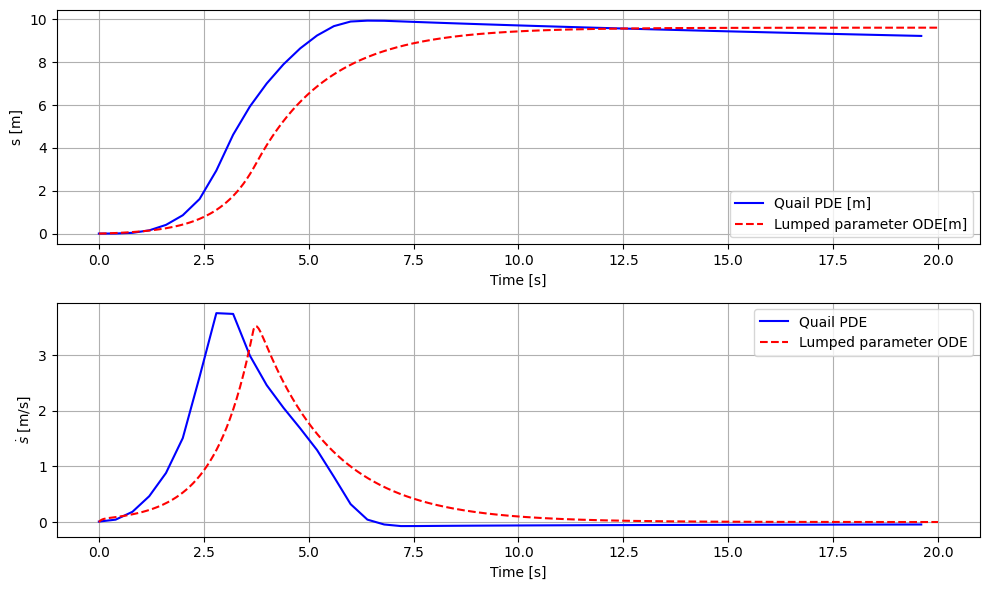

In [539]:
slip_dot = np.gradient(slip_time_series, times)

# Plot results
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(times, slip_time_series, 'b-', label='Quail PDE [m]')
plt.plot(t_lumped, s1, 'r--', label='Lumped parameter ODE[m]')
plt.xlabel("Time [s]")
plt.ylabel("s [m]")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(times, slip_dot, 'b-', label='Quail PDE')
plt.plot(t_lumped, s2, 'r--', label='Lumped parameter ODE')
plt.xlabel("Time [s]")
plt.ylabel("$\dot{s}$ [m/s]")
plt.grid(True)
plt.legend()

plt.savefig(f"{BASE_PATH}/volcano_sims/notebooks/charts/lumped_parameter_model.png")
plt.tight_layout()
plt.show()

## 2.0 Adding atmosphere 

First, let's review our mesh. I have modified it to have a 10m radius and very small triangles in and around the the conduit. Here are the results. 


/Users/paxton/git/quail_volcano/src

Points: (2902, 3)
Cells: dict_keys(['line', 'triangle'])
Cell Sets: {}


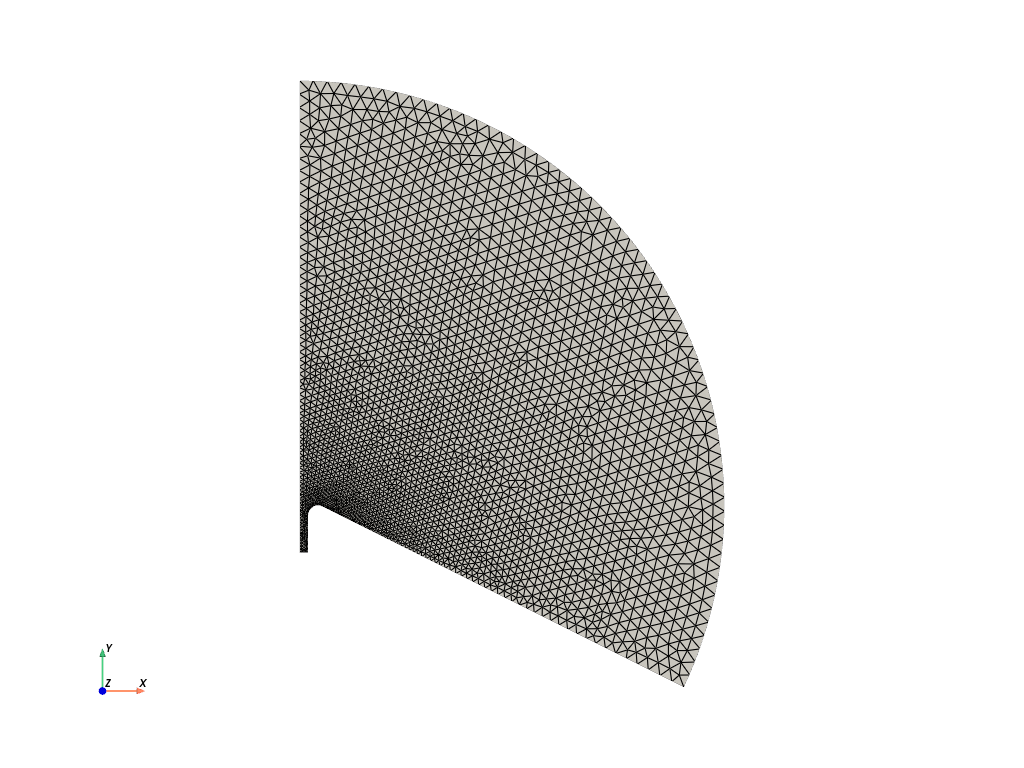

In [540]:
import meshio
import pyvista as pv
import os

print(os.getcwd())

mesh = meshio.read(f"{BASE_PATH}/quail_volcano/scenarios/meshes/tungurahuaA1.msh")

# Clear cell sets to avoid the error
mesh.cell_sets.clear()

# Print mesh details
print("Points:", mesh.points.shape)
print("Cells:", mesh.cells_dict.keys())
#for cell_type, cell_data in mesh.cells_dict.items():
    #print(f"Cell type {cell_type}: {cell_data.shape}")
print("Cell Sets:", mesh.cell_sets)
#print("Cell Data:", mesh.cell_data)

pv.set_jupyter_backend('static')

# Convert to pyvista mesh
pv_mesh = pv.from_meshio(mesh)

# Create a plotter and visualize
plotter = pv.Plotter()

plotter.add_mesh(pv_mesh, show_edges=True, color="white")
plotter.set_scale(xscale=1.0, yscale=1.0, zscale=1.0)
plotter.camera.roll += 80

plotter.view_xy()  # For 2D meshes; use view_isometric() for 3D
plotter.show_axes()
plotter.show()

In [541]:
file_name = "short_plug_v15"
iters = 200
solver_func = get_local_solver_from_index_func(folder_name, file_name)
ani = animate_conduit_pressure(solver_func, iterations=iters, d_iterations=4, viscosity_index=2, wall_friction_index=1, max_velocity=5, max_slip=60, max_tau=1.5, max_pressure=50, max_speed_of_sound=1000, max_water=1, max_density=5e3, max_fragmentation=5000, max_crystal=100, max_viscosity=0.1)

ani.save(f'{BASE_PATH}/volcano_sims/notebooks/animations/small_controlled_eruption.mp4', writer='ffmpeg', fps=10, bitrate=1800)
HTML(ani.to_html5_video())

In [542]:
viscosity_index = 2
atm_slip_time_series = []
atm_times = []
file_name = "short_plug_v15"
iters = 200
solver_func = get_local_solver_from_index_func(folder_name, file_name)

for i in range(0, iters, 4):
    solver = solver_func(i)
    arhoA = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityA")]
    arhoWt = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityWt")]
    arhoWv = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityWv")]
    arhoC = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityC")]
    arhoM = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityM")]
    arhoF = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityFm")]

	# Get the value of the new state variable.
    rho_mix = arhoA + arhoWv + arhoM + arhoF
    momentum = solver.state_coeffs[:,:,solver.physics.get_momentum_slice()]
		
    # Get the value of the new state variable.
    atm_slip_time_series.append((solver.state_coeffs[:,:,solver.physics.get_state_index("rhoSlip")]/rho_mix).ravel()[-1])
    atm_times.append(solver.time)

<>:20: SyntaxWarning: invalid escape sequence '\d'
<>:20: SyntaxWarning: invalid escape sequence '\d'
/var/folders/f7/g7y34v812n5_58yvtkt3mrw40000gn/T/ipykernel_20974/2314690185.py:20: SyntaxWarning: invalid escape sequence '\d'
  plt.ylabel("$\dot{s}$ [m/s]")


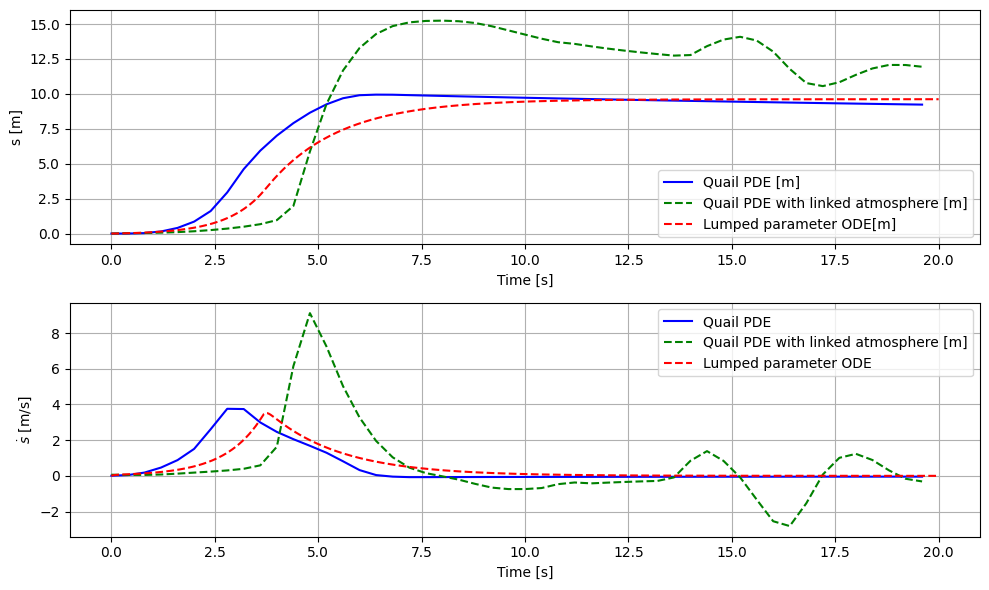

In [543]:
atm_slip_dot = np.gradient(atm_slip_time_series, atm_times)

# Plot results
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(times, slip_time_series, 'b-', label='Quail PDE [m]')
plt.plot(atm_times, atm_slip_time_series, 'g--', label='Quail PDE with linked atmosphere [m]')
plt.plot(t_lumped, s1, 'r--', label='Lumped parameter ODE[m]')
plt.xlabel("Time [s]")
plt.ylabel("s [m]")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(times, slip_dot, 'b-', label='Quail PDE')
plt.plot(atm_times, atm_slip_dot, 'g--', label='Quail PDE with linked atmosphere [m]')
plt.plot(t_lumped, s2, 'r--', label='Lumped parameter ODE')
plt.xlabel("Time [s]")
plt.ylabel("$\dot{s}$ [m/s]")
plt.grid(True)
plt.legend()

plt.savefig(f"{BASE_PATH}/volcano_sims/notebooks/charts/lumped_parameter_model.png")
plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (3196,3,1) (5562,3,1) 

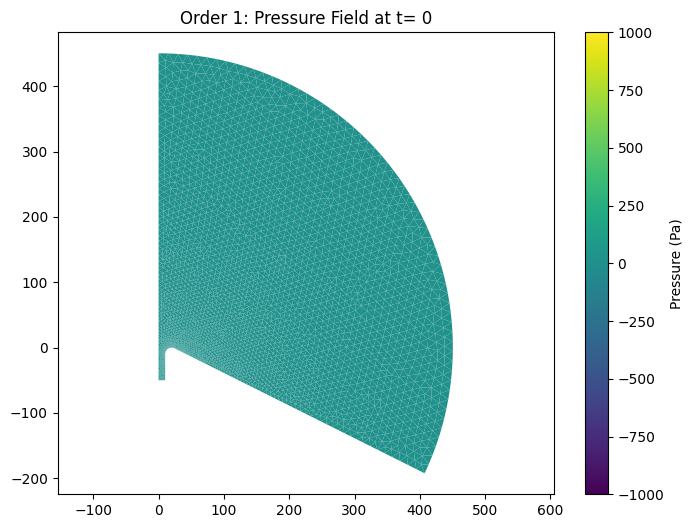

In [544]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import numpy as np
import processing.mdtools as mdtools

iterations = 400

# Assume solver2D_from is available as in the original code
solver2D_atm1 = get_local_solver_from_index_func("simple_conduit", "test_infrasound_v1_atm1")

# Set up figure
fig = plt.figure(figsize=(8, 6))

# Define pressure range for colormap
clims = (-1e3, 1e3)

# Set up colorbar
sm = plt.cm.ScalarMappable(
    norm=colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap()
)
cb = plt.colorbar(sm, ax=plt.gca())
cb.set_label("Pressure (Pa)")
x1, p1_0= mdtools.downsample(solver2D_atm1(0), plot_qty="Pressure")

# Animation update function
def update(frame):
    plt.cla()  # Clear current axis
    # Fetch data for current frame
    x1, p1= mdtools.downsample(solver2D_atm1(frame), plot_qty="Pressure")
    # Update plot
    mdtools.plot_mean(x1, p1 - p1_0, clims)
    plt.title(f"Order 1: Pressure Field at t= {round(solver2D_atm1(frame).time)}")
    return plt.gca(),

# Create animation
# Assume 100 frames for simulation; adjust based on solver data
ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(0, iterations, 8),  # Adjust range based on available solver indices
    interval=100,  # Time between frames in milliseconds
    blit=False
)

display(HTML(ani.to_html5_video()))
ani.save(f'{BASE_PATH}/volcano_sims/notebooks/animations/quail_small_eruption.mp4', writer='ffmpeg', fps=10, bitrate=1800)
plt.close(fig)  # Clean up

In [ ]:
import matplotlib.tri as tri
from helper_code.infrasound import *
solver_2D = solver2D_atm1(0)

triangulation = tri.Triangulation(solver_2D.mesh.node_coords[...,0],
                  solver_2D.mesh.node_coords[...,1], 
                  triangles=solver_2D.mesh.elem_to_node_IDs)
trifinder = triangulation.get_trifinder()

p_100 = infrasound.get_p_series(100, 0, solver2D_atm1, trifinder, iterations=400, p0=1e5)
p_250 = infrasound.get_p_series(250, 0, solver2D_atm1, trifinder, iterations=400, p0=1e5)
p_400 = infrasound.get_p_series(400, 0, solver2D_atm1, trifinder, iterations=400, p0=1e5)

Element ID for point (100, 0): 838
Element ID for point (250, 0): 433
Element ID for point (400, 0): 3049


Max pressure value at r=2000m is 5.613487566105323


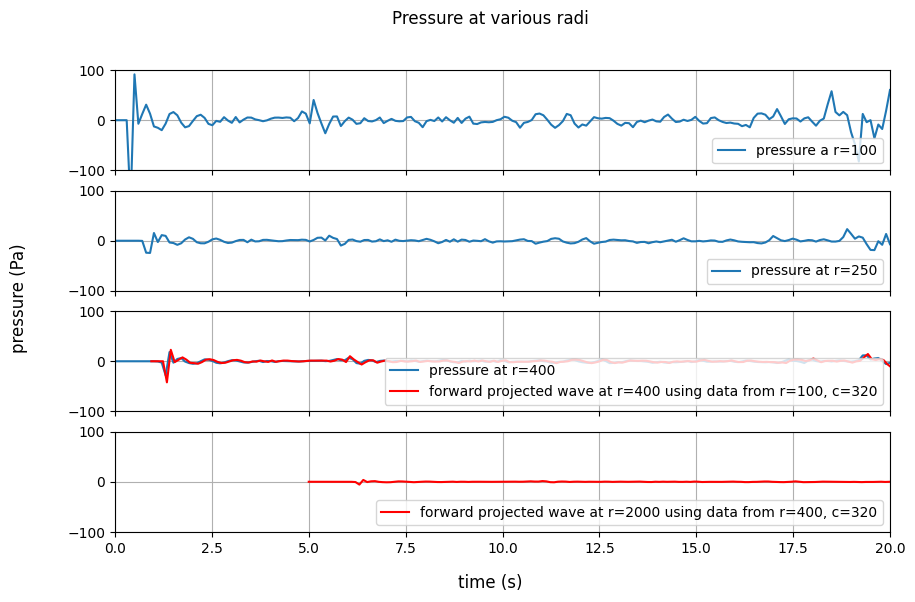

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 6), sharex=True)
t = np.linspace(0, 20, len(p_100))
C0 = 320

axes[0].plot(t, p_100, label="pressure a r=100")
axes[1].plot(t, p_250, label="pressure at r=250")
axes[2].plot(t, p_400, label="pressure at r=400")


p_400_sim = np.asarray(p_100) * 100/400
t_adjusted_400 = t + 300/320

p_2000_sim = np.asarray(p_400) * 400/2000
t_adjusted_2000 = t + 1600/320


axes[2].plot(t_adjusted_400, p_400_sim, label="forward projected wave at r=400 using data from r=100, c=320", c='r')
axes[3].plot(t_adjusted_2000, p_2000_sim, label="forward projected wave at r=2000 using data from r=400, c=320", c='r')

for i, ax in enumerate(axes):
    ax.legend(loc='lower right')
    ax.grid(True)
    ax.set_ylim(-100, 100)  
    ax.set_xlim(0, 20)

fig.suptitle("Pressure at various radi")
fig.supylabel("pressure (Pa)")
fig.supxlabel("time (s)")

print(f"Max pressure value at r=2000m is {max(np.abs(p_2000_sim))}")

## Lighthill Stress tensor

In [ ]:
import helper_code.lighthill as lighthill
import numpy as np
import matplotlib.tri as tri

def solver_from_2D(dom, i):
    solver_func = get_local_solver_from_index_func("simple_conduit", f"test_infrasound_v1_atm{dom}")

    return solver_func(i)

# Prep interpolation grid
solver0 = solver_from_2D(1, 0)
physics = solver0.physics
base_x = np.linspace(0, 300, 200)
base_y = np.linspace(-200, 800, 200)
mg_x, mg_y = np.meshgrid(base_x, base_y, indexing="xy")

solver0_list = [solver_from_2D(dom_idx, 0) for dom_idx in [1]]
# Compute workload partition
ind_partition = [np.where(tri.Triangulation(
  solver.mesh.node_coords[...,0],
  solver.mesh.node_coords[...,1], 
  triangles=solver.mesh.elem_to_node_IDs).get_trifinder()(mg_x.ravel(), mg_y.ravel()) != -1)[0]
  for solver in solver0_list]

# List of file indices to read
file_index_list = np.arange(0,iterations,1)

In [ ]:
# Allocate union (joining all times) U, in spatially-flattened shape
U_union = np.nan * np.empty((file_index_list.size, *mg_x.ravel().shape, 8+physics.NDIMS))

for time_idx, file_idx in enumerate(file_index_list):

	# Load solvers for given time_idx
	solver_list = [solver_from_2D(dom_idx, file_idx) for dom_idx in [1]]

	for solver, _index_partition in zip(solver_list, ind_partition):
		# Identify physical position (x, y) of points to interpolate at with shape (npoints, 2)
		_phys_pos = np.stack(
			(mg_x.ravel()[_index_partition],
			mg_y.ravel()[_index_partition]),
			axis=1)
		# Identify element indices for all points to interpolate at
		elt_indices = tri.Triangulation(
			solver.mesh.node_coords[...,0],
			solver.mesh.node_coords[...,1], 
			triangles=solver.mesh.elem_to_node_IDs).get_trifinder()(_phys_pos[:,0], _phys_pos[:,1])

		# Identify element node coordinates
		x_tri = solver.mesh.node_coords[solver.mesh.elem_to_node_IDs]
		# Compute global physical-to-reference coordinate mapping
		ref_mapping = lighthill.compute_ref_mapping(x_tri)

		# Interpolate for each point using the correct element, writing to correct index in global U array
		for (write_idx, x_point, ie) in zip(_index_partition, _phys_pos, elt_indices):
			# For element containing point, compute reference coordinate of sampling point
			ref_coords_loc = np.einsum("ij, j -> i",
																ref_mapping[ie,...],
																x_point - x_tri[ie,0,:])
			# Evaluate basis at reference coordinate
			#U_union[time_idx,write_idx,:] = (solver.state_coeffs[ie,0,:] * (1 - ref_coords_loc[0] - ref_coords_loc[1]))

			U_union[time_idx,write_idx,:] = (solver.state_coeffs[ie,0,:] * (1 - ref_coords_loc[0] - ref_coords_loc[1]) + solver.state_coeffs[ie,1,:] * ref_coords_loc[0] + solver.state_coeffs[ie,2,:] * ref_coords_loc[1])

In [ ]:
# Evaluate temperature using interpolated state, migrate to meshgrid shape (time_indices, mg_x.shape[0], mg_x.shape[1])
T_interp = np.reshape(physics.compute_variable("Temperature", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
rho = U_union[...,0:3].sum(axis=-1, keepdims=True)
yM = np.reshape(U_union[...,2:3] / rho, (file_index_list.size, *mg_x.shape))

t_range = np.linspace(0, 12.5, T_interp.shape[0])

In [ ]:
rho = U_union[...,0:3].sum(axis=-1, keepdims=True)
u = U_union[:,:,3:4] / rho
v = U_union[:,:,4:5] / rho

# Pull rho, u, v
mg_u = np.reshape(u, (file_index_list.size, *mg_x.shape))
mg_v = np.reshape(v, (file_index_list.size, *mg_x.shape))
mg_T = np.reshape(physics.compute_variable("Temperature", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_p = np.reshape(physics.compute_variable("Pressure", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_rho = np.reshape(rho, (file_index_list.size, *mg_x.shape))
mg_c = np.reshape(physics.compute_variable("SoundSpeed", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_p0 = mg_p[0,...]

In [ ]:
# Grid dimensions
dx = np.diff(mg_x[0:1,:], axis=1)
dy = np.diff(mg_y[:,0:1], axis=0)
# Grid-center coordinates
center_x = 0.5 * (mg_x[:,1:] + mg_x[:,:-1])[:-1,:]
center_y = 0.5 * (mg_y[1:,:] + mg_y[:-1,:])[:,:-1]

# Grid-center differentiation
u_foldx = (0.5 * (mg_u[:,:,1:] + mg_u[:,:,:-1]))
u_foldy = (0.5 * (mg_u[:,1:,:] + mg_u[:,:-1,:]))
dudy = np.diff(u_foldx, axis=1) / dy
dudx = np.diff(u_foldy, axis=2) / dx

v_foldx = (0.5 * (mg_v[:,:,1:] + mg_v[:,:,:-1]))
v_foldy = (0.5 * (mg_v[:,1:,:] + mg_v[:,:-1,:]))
dvdy = np.diff(v_foldx, axis=1) / dy
dvdx = np.diff(v_foldy, axis=2) / dx

mg_c0 = mg_c[0,...]
# Grid-center coordinates
center_x = 0.5 * (mg_x[:,1:] + mg_x[:,:-1])[:-1,:]
center_y = 0.5 * (mg_y[1:,:] + mg_y[:-1,:])[:,:-1]
# Interior grid-center coordinates
int_x = center_x[1:-1,1:-1]
int_y = center_y[1:-1,1:-1]

In [ ]:
# Evaluate matrix T
T00_nonlinear = mg_p - mg_c0*mg_c0 * mg_rho
T01_nonlinear = np.zeros_like(mg_rho)
T10_nonlinear = np.zeros_like(mg_rho)
T11_nonlinear = mg_p - mg_c0*mg_c0 * mg_rho

# Mixed derivative (symmetric)
d2T01 = (np.diff(np.diff(T01_nonlinear, axis=-1), axis=-2) / dx) / dy

# d^2(T00)/dx^2
T00_foldy = 0.5 * (T00_nonlinear[:,1:,:] + T00_nonlinear[:,:-1,:])
d2T00 = T00_foldy[:,:,3:] - T00_foldy[:,:,2:-1] - T00_foldy[:,:,1:-2] + T00_foldy[:,:,0:-3]
# d^2(T11)/dy^2
T11_foldx = 0.5 * (T11_nonlinear[:,:,1:] + T11_nonlinear[:,:,:-1])
d2T11 = T11_foldx[:,3:,:] - T11_foldx[:,2:-1,:] - T11_foldx[:,1:-2,:] + T11_foldx[:,0:-3,:]

# Evaluate Lighthill analogy source at cell center, for interior cells (discard boundary cells)
dijTij_nonlinear = d2T00[:,1:-1,:] + 2 * d2T01[:,1:-1,1:-1] + d2T11[:,:,1:-1]

In [ ]:
# Evaluate matrix T
T00_inertial = mg_rho * mg_u * mg_u
T01_inertial = mg_rho * mg_u * mg_v
T10_inertial = mg_rho * mg_v * mg_u
T11_inertial = mg_rho * mg_v * mg_v

# Mixed derivative (symmetric)
d2T01 = (np.diff(np.diff(T01_inertial, axis=-1), axis=-2) / dx) / dy

# d^2(T00)/dx^2
T00_foldy = 0.5 * (T00_inertial[:,1:,:] + T00_inertial[:,:-1,:])
d2T00 = T00_foldy[:,:,3:] - T00_foldy[:,:,2:-1] - T00_foldy[:,:,1:-2] + T00_foldy[:,:,0:-3]
# d^2(T11)/dy^2
T11_foldx = 0.5 * (T11_inertial[:,:,1:] + T11_inertial[:,:,:-1])
d2T11 = T11_foldx[:,3:,:] - T11_foldx[:,2:-1,:] - T11_foldx[:,1:-2,:] + T11_foldx[:,0:-3,:]

# Evaluate Lighthill analogy source at cell center, for interior cells (discard boundary cells)
dijTij_inertial = d2T00[:,1:-1,:] + 2 * d2T01[:,1:-1,1:-1] + d2T11[:,:,1:-1]

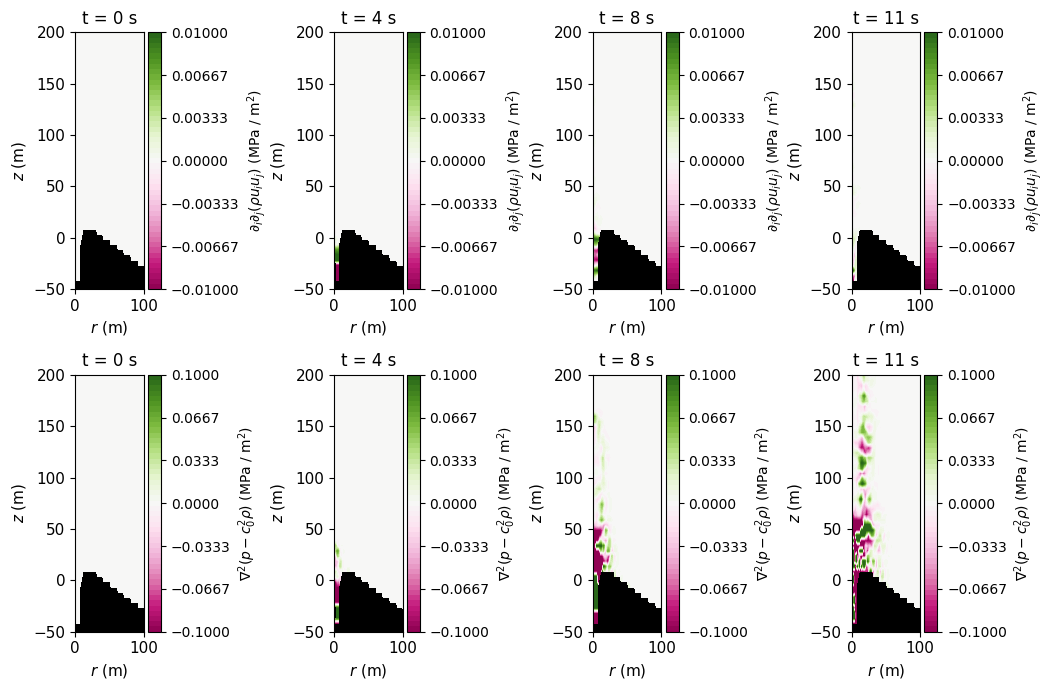

In [ ]:
import matplotlib
fig, ax = plt.subplots(2, 4, figsize=(10.5,7))

levels = np.linspace(-1e4, 1e4, 50) / 1e6
# t_indices = [3, 9, 36, 72]
t_indices = [0, 120, 240, 360]

for i, t_ind in enumerate(t_indices):
  ax[0,i].set_facecolor("black")
  cf = ax[0,i].contourf(int_x, int_y, np.clip(dijTij_inertial[t_ind,:,:] / 1e6, levels[0], levels[-1]), levels=levels, cmap=matplotlib.cm.PiYG)
  cb = fig.colorbar(cf, label=r"$\partial_i \partial_j (\rho u_i u_j)$ (MPa / m${}^2$)",
                    # format=matplotlib.ticker.FormatStrFormatter('%.3e')
                    )
  ax[0,i].set_xlim(0, 100)
  ax[0,i].set_ylim(-50, 200)
  #ax[0,i].set_aspect('equal')
  ax[0,i].set_xlabel("$r$ (m)")
  ax[0,i].set_ylabel("$z$ (m)")
  curr_ax = ax[0,i]
  for item in ([curr_ax.xaxis.label, curr_ax.yaxis.label] +
                curr_ax.get_xticklabels() + curr_ax.get_yticklabels()):
    item.set_fontsize(11)
  cb.set_ticks(np.linspace(levels[0], levels[-1], 7))
  ax[0,i].set_title(f"t = {round(t_range[t_ind])} s")
  # cb.ax.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%e'))

# fig.tight_layout()
  
# fig, ax = plt.subplots(1, 3, figsize=(8.5,3.5))

levels = np.linspace(-1e5, 1e5, 50) / 1e6
# t_indices = [3, 9, 36, 72]
t_indices = [0, 120, 240, 360]

for i, t_ind in enumerate(t_indices):
  ax[1,i].set_facecolor("black")
  cf = ax[1,i].contourf(int_x, int_y, np.clip(dijTij_nonlinear[t_ind,:,:] / 1e6, levels[0], levels[-1]), levels=levels, cmap=matplotlib.cm.PiYG)
  cb = fig.colorbar(cf, label=r"$\nabla^2 (p - c_0^2 \rho)$ (MPa / m${}^2$)",
                    # format=matplotlib.ticker.FormatStrFormatter('%.3e')
                    )
  ax[1,i].set_xlim(0, 100)
  ax[1,i].set_ylim(-50, 200)
  #ax[1,i].set_aspect('equal')
  ax[1,i].set_xlabel("$r$ (m)")
  ax[1,i].set_ylabel("$z$ (m)")
  curr_ax = ax[1,i]
  for item in ([curr_ax.xaxis.label, curr_ax.yaxis.label] +
                curr_ax.get_xticklabels() + curr_ax.get_yticklabels()):
    item.set_fontsize(11)
  cb.set_ticks(np.linspace(levels[0], levels[-1], 7))
  ax[1,i].set_title(f"t = {round(t_range[t_ind])} s")
  # cb.ax.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%e'))

fig.tight_layout()
plt.draw()
plt.savefig(f'{BASE_PATH}/volcano_sims/notebooks/charts/lighthill_tensor_double_divergence.png')

# Volume integral - lighthill

In [ ]:
import helper_code.lighthill as lighthill

source = dijTij_inertial + dijTij_nonlinear

print(source.shape)

x_obs = (2000, -1000, 0)
c0 = 320 # m/s roughly the speed of sound in air at 5000m in elevation
atmosphere_solid_angle = 4 * np.pi * (2/3)

X = int_x[0]
Y = int_y[:,0]

X = np.linspace(-100, 100, 20)
Y = np.linspace(0, 200, 20)
Z = np.linspace(-100, 100, 20)

points = (t_range, int_y[:,0], int_x[0])

pressure_obs = lighthill.calculate_pressure_as_volume_integral(X, Y, Z, file_index_list, x_obs, points, source, t_range, int_x[0][-1], c0)

(400, 197, 197)
DV size is 1166.3507799970844
Finished time index 0 of 400
Finished time index 10 of 400
Finished time index 20 of 400
Finished time index 30 of 400
Finished time index 40 of 400
Finished time index 50 of 400
Finished time index 60 of 400
Finished time index 70 of 400
Finished time index 80 of 400
Finished time index 90 of 400
Finished time index 100 of 400
Finished time index 110 of 400
Finished time index 120 of 400
Finished time index 130 of 400
Finished time index 140 of 400
Finished time index 150 of 400
Finished time index 160 of 400
Finished time index 170 of 400
Finished time index 180 of 400
Finished time index 190 of 400
Finished time index 200 of 400
Finished time index 210 of 400
Finished time index 220 of 400
Finished time index 230 of 400
Finished time index 240 of 400
Finished time index 250 of 400
Finished time index 260 of 400
Finished time index 270 of 400
Finished time index 280 of 400
Finished time index 290 of 400
Finished time index 300 of 400
Fini

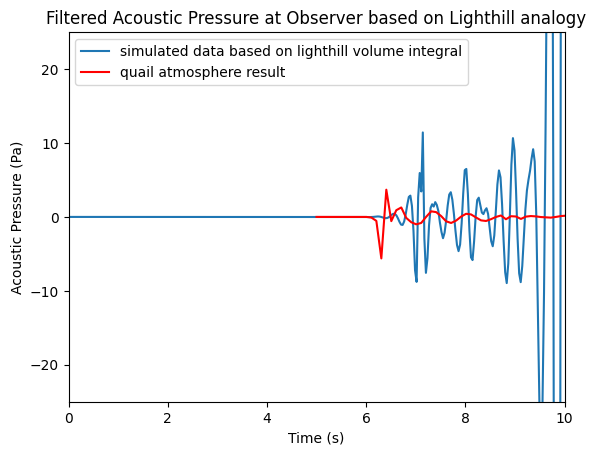

In [ ]:
plt.plot(t_range, lighthill.highpass(pressure_obs), label="simulated data based on lighthill volume integral")
plt.plot(t_adjusted_2000, p_2000_sim, label="quail atmosphere result", c='r')
plt.xlabel('Time (s)')
plt.ylabel('Acoustic Pressure (Pa)')
plt.title('Filtered Acoustic Pressure at Observer based on Lighthill analogy')
plt.xlim(0, 10)
plt.ylim(-25, 25)
plt.legend()

## Compare to monopole source simulation

In [ ]:
import matplotlib

file_name = "short_plug_v15"
iters = 200
solver_func = get_local_solver_from_index_func(folder_name, file_name)

u_vec = []
t_vec = []
R = 10 # m

for i in range(0, iters, 2):
    solver = solver_func(i)
    momentum = solver.state_coeffs[:,:,solver.physics.get_momentum_slice()]
    rho = np.sum(solver.state_coeffs[:, :, solver.physics.get_mass_slice()],axis=2,keepdims=True)

    # Define velocity as momentum divided by density. "velocity" when computed as an additional state variable appears to be an absolute value. 
    u = momentum.ravel() / rho.ravel()

    # Take only the exit velocity
    u_vec.append(np.maximum(u[-1], 0))
    t_vec.append(solver.time)

a_vec = np.gradient(np.array(u_vec), np.array(t_vec))
Q_dot_vec = np.pi * R**2 * a_vec # m^3/s^2

N = 100
pressure_array = np.zeros((len(t_vec), N, N))
x_low, x_upper = -500, 3000
y_low, y_upper = -1000, 2500

X = np.linspace(x_low, x_upper, N)
Y = np.linspace(y_low, y_upper, N)

# Set up the figure and axis
fig, ax = plt.subplots()
im = ax.imshow(pressure_array[0], extent=[x_low, x_upper, y_low, y_upper], 
               aspect='auto', cmap=matplotlib.cm.PiYG, origin='lower', vmin=-10, vmax=10)
plt.colorbar(im, label='Pressure (Pa)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Pressure Distribution Over Time')

# Initialization function for animation
def init():
    im.set_array(np.zeros((N, N)))
    return [im]

# Animation update function
def update(t):
    t_idx = np.argmin(np.abs(np.array(t_vec) - t))  # Find the closest index in t_vec
    for i in range(N):
        for j in range(N):
            x = X[i]
            y = Y[j]

            if infrasound.point_in_volcano(x, y):
                pressure_array[int(t_idx), j, i] = 0  # Set pressure to 0 inside volcano
            else:
                pressure_array[int(t_idx), j, i] = infrasound.relative_pressure(t, x, y, t_vec, Q_dot_vec)

    im.set_array(pressure_array[int(t_idx)])
    ax.set_title(f'Pressure Distribution at t={t:.2f} s')
    return [im]

# Create animation
ani = FuncAnimation(fig, update, init_func=init, frames=np.asarray(t_vec), 
                    interval=200, blit=True)

ani.save(f'{BASE_PATH}/volcano_sims/notebooks/animations/monopole_source.mp4', writer='ffmpeg', fps=10, bitrate=1800)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

Max pressure at r=2000m is 9.494032525638186 Pa


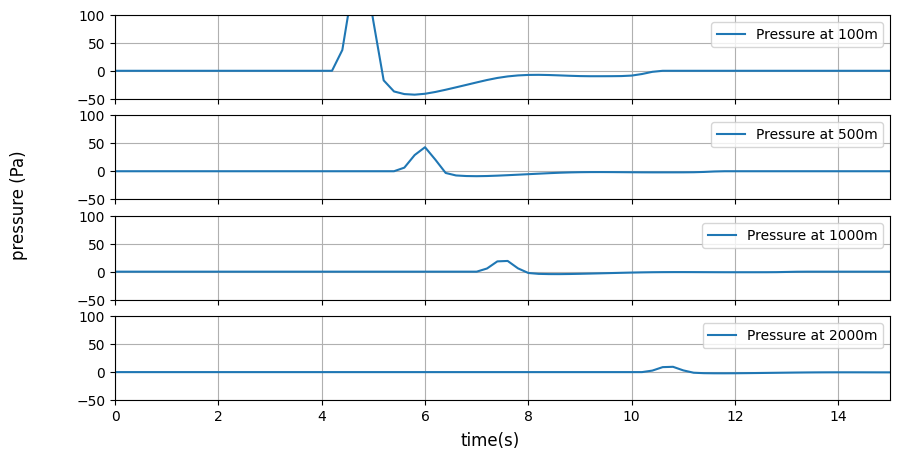

In [ ]:
y_idx = np.argmin(np.abs(Y))

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 5), sharex=True)

axes[3].plot(t_vec, pressure_array[:, y_idx, np.argmin(np.abs(X - 2000))], label="Pressure at 2000m")
axes[2].plot(t_vec, pressure_array[:, y_idx, np.argmin(np.abs(X - 1000))], label="Pressure at 1000m")
axes[1].plot(t_vec, pressure_array[:, y_idx, np.argmin(np.abs(X - 500))], label="Pressure at 500m")
axes[0].plot(t_vec, pressure_array[:, y_idx, np.argmin(np.abs(X - 100))], label="Pressure at 100m")

for i, ax in enumerate(axes):
    ax.legend(loc='upper right')
    ax.grid(True)
    ax.set_ylim(-50, 100)  
    ax.set_xlim(0, 15)

fig.supxlabel("time(s)")
fig.supylabel("pressure (Pa)")
plt.savefig(f"{BASE_PATH}/volcano_sims/notebooks/charts/monopole_pressure_vs_time.png")

print(f"Max pressure at r=2000m is {max(np.abs(pressure_array[:, y_idx, np.argmin(np.abs(X - 2000))]))} Pa")